# Missing
If silence:
1. Corroborate correct concatenation of non-silent segments division.
1. Corroborate label copy during segment division.
1. Add multichannel implementation to silence deletion function. Padding has it.
1. Analyze compatibility in pipeline between silence removal and padding.

Else:
1. Corroborate label copy during segment division.
1. Automate normalization.
1. Check directory implementation in image writing.
1. Choose WideResNet version.
1. Check what the normalization in NasNET is and its compatibility with databunch normalization.
1. Modify output layers, adapt to softmax with 80 classes (or 81?).
1. Check that label splitting in databunch creation works with multiple sigmoid.
1. Implement concatenation, new train/dev split for xgboost.
1. Check xgboost loss function.
1. Check lwlrap implementation and compatibility as callback.

# Imports

In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import os

# Access Drive from Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Preprocessing

In [0]:
# Preprocessing libraries
import librosa.feature as lrft
# from librosa import load as lbload
from librosa.display import specshow
import librosa.display
import librosa
import numpy as np
from scipy.io.wavfile import read
from scipy.signal import stft
from scipy import stats
from imageio import imwrite, imread
from zipfile import ZipFile
import IPython.display as ipd
import pandas as pd
import matplotlib.pyplot as plt
import numba

### Machine learning

In [0]:
# Libraries for neural nets
from fastai import *
from fastai.vision import *
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.utils.model_zoo as model_zoo  # no lo usamos, o sí?
import torchvision.models as models
from torch.autograd import Variable
# XGBoost
import xgboost as xgb
import sklearn.metrics
from sklearn.model_selection import train_test_split

# Labels processing

Importación de archivos de _labels_.

In [184]:
# Carpeta del Drive de Ivo para FSD tagging
# os.chdir('gdrive/My Drive/Colab Notebooks/Freesound tagging')
data = pd.read_csv('train_curated.csv')
noisy_data = pd.read_csv('train_noisy.csv')
data = data.set_index("fname", drop=True)
# data.head()
data.info()
noisy_data.info()
# data.summary()

FileNotFoundError: ignored

Both noisy and curated datasets have no null entries.

## Wrangling

Mainly one-hot encoding.

The labels file contains only one column where all multi-class labels reside. Therefore, split it we must.

In [0]:
labels = data["labels"].str.split(",", n=-1, expand=True)

Make labels categorical again.

In [0]:
data["label0"] = labels[0].astype('category')
data["label1"] = labels[1].astype('category')
data["label2"] = labels[2].astype('category')
data["label3"] = labels[3].astype('category')
data["label4"] = labels[4].astype('category')
data.drop(columns="labels", inplace=True)
data.head()

,label0,label1,label2,label3,label4
fname,,,,,
0006ae4e.wav,Bark,NaN,NaN,NaN,NaN
0019ef41.wav,Raindrop,NaN,NaN,NaN,NaN
001ec0ad.wav,Finger_snapping,NaN,NaN,NaN,NaN
0026c7cb.wav,Run,NaN,NaN,NaN,NaN
0026f116.wav,Finger_snapping,NaN,NaN,NaN,NaN


In [0]:
data.describe()  # just checking

,label0,label1,label2,label3,label4
count,4970,701,74,5,1
unique,78,47,12,3,1
top,Zipper_(clothing),Strum,Cheering,Gurgling,Clapping
freq,75,75,38,3,1


There are files with up to 5 labels simultaneously, so one-hot encoding is a must.

### One-hot encoding

In [0]:
data_ohdup = pd.get_dummies(data, prefix='', prefix_sep='')
data_ohdup.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4970 entries, 0006ae4e.wav to ffff4631.wav
Columns: 141 entries, Accelerating_and_revving_and_vroom to Clapping
dtypes: uint8(141)
memory usage: 723.2+ KB


If you pay attention, from 80 categories specified we suddenly got 141 columns. Some of them, those with entries in more than one "label#" column, were duplicated with the split. The following steps collapse them back into one column per class.

#### Duplicate columns collapsing

In [0]:
def collapse_duplicate_cols(df):
    nondupdf = pd.DataFrame([])
    for col in df.columns:
        if len(df[col].shape) > 1:
            cols = df[col].shape[1]
            if cols > 1:
                if col not in nondupdf.columns:
                    nondupdf[col] = df[col].sum(axis=1)
                else: pass
        else:
             nondupdf[col] = df[col]
    return nondupdf

In [0]:
data_oh = pd.DataFrame([])
data_oh = collapse_duplicate_cols(data_ohdup)
counts_oh = data_oh.apply(lambda col: col.sum(), axis=0)

In [0]:
data_oh[data_oh.sum(axis=1) > 2].head()

,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,Gong,Gurgling,Harmonica,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing),Strum,Water_tap_and_faucet
fname,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
07b01fb0.wav,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
088aafb8.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
0abe5490.wav,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10ddcfd5.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12f56dc6.wav,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we can see that some events that are intuitively related occur simultaneously in the dataset, such as cheering, crowd and applause or washing and dripping.

### Construcción de pesos por frecuencia

One can see that each category has its own frequency in the training dataset, so, in order to prevent bias coming from this, weighing vectors are constructed to amplify (or not) the gradients of each class during learning.

In [0]:
freqs = counts / counts.sum()
print(freqs)

**By comparing against the mean**

In [0]:
weights_mean = counts.mean() / counts
print(weights_mean)

**By comparing against the max**

In [0]:
weights_max = counts.max() / counts
print(weights_max)

# Data preprocessing


**FALTA:**

* **Ver cómo deben estructurarse los directorios para fastai**
* **Automatizar la lectura y transformación de todos los archivos.**
* **Transformar la salida de la eliminación de silencios en nuevas entradas de la base de datos.**
#### Opción alternativa: crear ItemBase y ItemList. No implementada.
importar audios como ItemList de ItemBase => aplicar transformaciones

### Data processing flow
1.   Transformation:
    *   MP3 encoding for data augmentation? Not implemented.
    *   Audio files are read, then transformed parallely into a mel spectrogram and CQT magnitude and phase spectrograms.
1.   Processing:
    *   Silence removal: spectrograms are split at silence intervals, which are deleted, and remaining segments are kept as new individual entries in the training set.
    *   Padding: spectrogram dimesions are homogenized both in time and frequency axes and ajusted to the neural networks minimum size.
    *   Normalization/standardization: data are turned into gaussian normal.
1.   MixUp: it is used as data augmentation/regularization during training, as implemented in fastai.

## Feature engineering:
Para crear más features y/o ayudar a la regularización gracias a domain knowledge, ideas posibles para transformar los audios son:
- **Transformaciones típicas**: melspectrograma, coeficientes mel, transformada Q constante, transformada wavelets. La primera ha dado mejores resultados en redes neuronales. MFCC fuerza ortogonalidad lo que podría obstaculizar la generalización al provocar especialización de los filtros de las redes.
- **Conversión a mp3**: menor espacio en disco, menores tiempos de carga a memoria, posibles beneficios en cuanto a regularización por pérdida de "definición", por ponerle un nombre.
- **Traslaciones en frecuencia**: data augmentation y regularización por "deformar" features.
- **Cortar audios** en pequeños segmentos de misma duración: además de ser necesario para el funcionamiento de la red neuronal convolutiva, permite data augmentation sin modificar la distribución de los datos.

In [4]:
""" Acomodar directorios a carpetas de audios.
"""
# os.getcwd()
# os.chdir("../input")  # kaggle/input
os.listdir()

['.config', 'gdrive', 'sample_data']

### wav -> mp3
La idea es usar la conversión a mp3 para aprovechar su alinealidad y los parámetros que tal formato pondera del oído humano para acercar al modelo a la human level performance.

In [0]:
# os.getcwd()
# path_curated = os.getcwd() + "/train_curated"
# print(path_curated)
# os.listdir(path_curated)

# file = path_curated + 'a17b177a.wav'
# cmd = 'lame --preset insane %s' % file
# subprocess.call(cmd, shell=True)
# print('a17b177a.wav.mp3' in os.listdir(path_curated))

# os.chdir('train_curated')
# os.getcwd()
file = 'a17b177a.wav'
cmd = 'lame --preset insane %s' % file
subprocess.call(cmd, shell=True)
print('a17b177a.wav.mp3' in os.listdir())

# for file in os.listdir(path+"/train_curated"):
#     # chequear que file es "str.wav"
#     cmd = 'lame --preset insane %s' % file
#     subprocess.call(cmd, shell=True)
#     cmd = 'mpg123 -w %s_tfmd.wav %s.wav.mp3' % file[:-4]  # necesita una pausa?
#     subprocess.call(cmd, shell=True)

### Transformaciones CQT, espectrograma Mel

A cada archivo se le calcula el espectrograma Mel y la transformada de Q constante por separado. Las salidas se "apilan" antes de los siguientes pasos de procesamiento (división por silencios y _padding_).

**FALTA en la transformación:**
- Que se realice sobre TODOS los archivos
- Guardar en una estructura de directorios que simplifique la importación por fastai

#### Read/transform functions

Based on daisukelab's kernel: https://www.kaggle.com/daisukelab .

In [0]:
def read_audio(conf, pathname, trim_long_data=False):
    y, _ = librosa.load(pathname, sr=conf.sampling_rate)
    return y

def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio,
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax
                                                )
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def audio_to_cqtspectrogram(conf, audio):
    spectrogram = librosa.core.hybrid_cqt(audio, sr=conf.sampling_rate,
                                          hop_length=conf.hop_length,
                                          fmin=conf.fmin,
                                          n_bins=conf.n_mels,
                                          bins_per_octave=conf.bins_per_octave,
                                          tuning=0.0, filter_scale=1, norm=1,
                                          sparsity=0, scale=False,
                                          pad_mode='constant')
    cqtm, cqtp = librosa.magphase(spectrogram)
#     spectrogram = librosa.power_to_db(spectrogram)
    cqtm, cqtp = cqtm.astype(np.float32), cqtp.astype(np.float32)
    return (cqtm, cqtp)

def audio_to_spectrogram(conf, audio):
    sepctrogram = librosa.stft(audio, n_fft=conf.n_fft,
                               hop_length=conf.hop_length, pad_mode='constant')
    stftmag, stftphase = librosa.magphase(spectrogram)
    return (stftmag, stftphase)

def show_melspectrogram(conf, spec, title='Log-frequency power spectrogram'):
    librosa.display.specshow(spec, x_axis='time',
                             y_axis='mel',
                             sr=conf.sampling_rate,
                             hop_length=conf.hop_length,
                             fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def show_cqtspectrogram(conf, spec, title='Log-frequency power spectrogram'):
    librosa.display.specshow(spec, x_axis='time',
                             y_axis='cqt_hz',
                             sr=conf.sampling_rate,
                             hop_length=conf.hop_length,
                             fmin=1)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def read_as_spectrogramsx3(conf, pathname, trim_long_data=False,
                           debug_display=False):
    x = read_audio(conf, pathname, trim_long_data=trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    cqtm, cqtp = audio_to_cqtspectrogram(conf, x)
    # specs = np.stack((mels, bins), axis=2)
    if debug_display:
        ipd.display(ipd.Audio(x, rate=conf.sampling_rate))
        # IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return [mels, cqtm, cqtp]

In [0]:
class conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 2
    fmin = 10
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 8
    bins_per_octave = 24
    hop_length = n_fft // 2  # to make time steps 224
    samples = sampling_rate * duration
    pad_mode = "constant"

Ejemplo:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


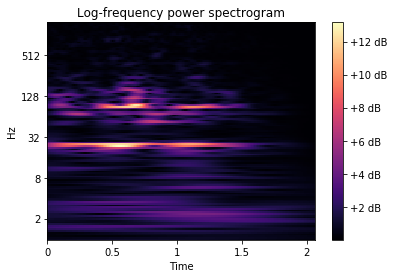

In [0]:
# os.chdir("gdrive/My Drive/Colab Notebooks/Freesound tagging/train_curated")
# os.listdir()
audio = read_audio(conf, 'train_curated/0019ef41.wav')
cqtm, cqtp = audio_to_cqtspectrogram(conf, audio)
show_cqtspectrogram(conf, cqtm)

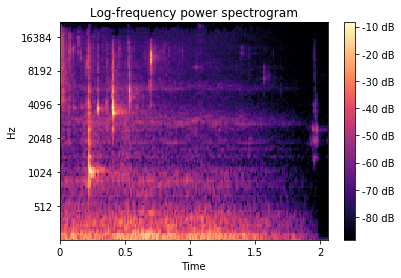

In [0]:
melspec = audio_to_melspectrogram(conf, audio)
show_melspectrogram(conf, melspec)

In [0]:
filespec = read_as_spectrogramsx3(conf, '0019ef41.wav')
print("Melspectrogram shape: ", filespec[0].shape)
print("CQT spectrogram shape: ", filespec[1].shape)
print("CQT phase spectrogram shape: ", filespec[2].shape)

Melspectrogram shape:  (128, 359)
CQT spectrogram shape:  (128, 359)
CQT phase spectrogram shape:  (128, 359)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


#### Importación y transformación

In [0]:
from IPython.display import clear_output

# os.chdir("gdrive/My Drive/Colab Notebooks/Freesound tagging/train_curated")
batch = []
i = 0
for file in os.listdir():  # especificar el directorio
    i += 1
    filespec = read_as_spectrogramsx3(conf, file)
    # batch.append(filespec)
    clear_output()
    np.savetxt(f"../specs_unprocessed/{file}_mel.csv", filespec[0])
    np.savetxt(f"../specs_unprocessed/{file}_cqtm.csv", filespec[1])
    np.savetxt(f"../specs_unprocessed/{file}_cqtp.csv", filespec[2])
    print(f"{i} out of {len(os.listdir())} done.")
labels = data_oh.loc[os.listdir()]
del data_oh

# RANDOM just for testing the code
# import random
# batch = []
# picks = random.choices(os.listdir(), k=5)
# for name in picks:  # especificar el directorio
#     filespec = read_as_spectrogramsx3(conf, name)
#     batch.append(filespec)
# labels = data_oh.loc[picks]

1293 out of 4970 done.


In [212]:
# !unzip "train_curated.zip" -d "train_curated"
# os.listdir()
print(f"Set is {len(batch)} files long.")
print(os.listdir()[0])
labels.head()
# data_oh.head()

Set is 4970 files long.
c1b84d6f.wav


,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,Gong,Gurgling,Harmonica,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing),Strum,Water_tap_and_faucet
fname,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0006ae4e.wav,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0019ef41.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
001ec0ad.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0026c7cb.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0026f116.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Just checking**

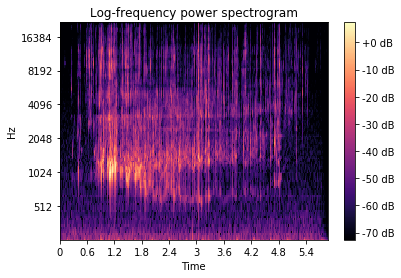

In [233]:
print(labels.iloc[1574].to_numpy().nonzero()[0][0])  # == 33
print(labels.columns[33])  # == "Fill_(with_liquid)"
labels.iloc[1547]["Fill_(with_liquid)"]  # == 1
show_melspectrogram(conf, batch[1547][0], title='Log-frequency power spectrogram')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


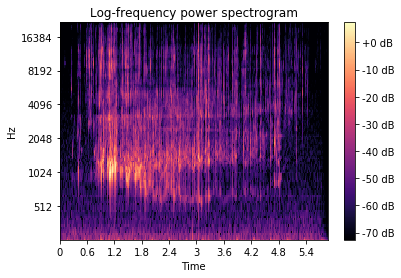

In [238]:
chota, _, _ = read_as_spectrogramsx3(conf, os.listdir()[1547],
                                     trim_long_data=False,
                                     debug_display=True)

Looks OK.

### Eliminación de silencio

División en segmentos, promediado RMS, eliminación de segmentos silenciosos, conservación de segmentos no silenciosos con segmentos adyacentes.

**FALTA:**
* **Programar que corra sobre todos los archivos de un set de datos**
* **Hacer que funcione correctamente en simultáneo para espectrogramas "RGB"**
* **Implementar manejo de dimensiones de salida (según cantidad de segmentos sonoros detectados)**
* **Implementar que se copie la etiqueta para los varios segmentos de un mismo archivo**


La función que se debe llamar para cada archivo es del_silence(). Las otras que figuran a continuación son llamadas por ella como parte del proceso.

    del_silence(spec: [array] espectrograma, seg_frames: [int] duración de segmentos, thresh=-60 [int/float] umbral de silencio en dB)

#### NumPy


Use only one of the following.

**Single channel version**

In [0]:
# def rms_wrap(spec, idx, n_fft, on='magnitude'):
#     return rms(spec, idx, n_fft, on=on)
#
# @numba.jit(nopython=True, parallel=True)
def rms(spec, idx, n_fft, on='magnitude'):
    """ RMS of a single frame of a spectrogram
    """
    if on == 'magnitude':
        return 10 * np.log10(np.sum(np.power(10, spec[:, idx] * 0.1)))
    elif on == 'amplitude':
        return np.sqrt(np.sum(spec[:, idx] ** 2) / n_fft)
    else:
        raise ValueError("Expected \"amplitude/magnitude\", got ", on, ".")

# def del_silence_wrap(spec, n_fft, on='magnitude', thresh=1.e-6):
#     split = spec
#     t = 0
#     prevsil = True
#     RMS = 0
#     del_silence(spec, n_fft, split, prevsil, t, RMS, on=on, thresh=thresh)
#     return non_silent_segments
#
# @numba.jit(nopython=True, parallel=True)
def del_silence(spec, n_fft, on='magnitude', thresh=1.e-6):
    """ Delete silent segments in spectrograms.
    
    Arguments:
    spec - array of shape (n_mel or n_fft, n_frames, 3). The first channel
        contains the power mel spectrogram, the second one the CQT magnitude
        spectrogram and the last one the CQT phase spectrogram. Silence is
        calculated on the power mel spectrogram.
    n_fft - int. Number of frequency bins.
    
    Returns:
    non_silent_segments - array of shape (n_mel or n_fft, N, 3) where N
        is the number of non-silent frames found.
    """
    non_silent_segments = []
    split = spec
    prevsil = True
    t = 0
    while True:
        RMS = rms(split[:, :, 0], t, n_fft, on=on)
        if (RMS < thresh) and not prevsil:
            # si pasa de sonido a silencio
            split = np.split(split, [t+1], axis=1)  # [t+1] por padding
            if t % 50 == 0:
                print(split[0])
            non_silent_segments.append(np.squeeze(split[0]))
            t -= split[0].shape[1]  # chequear
            # del split[0]
            split = split[1]            
            prevsil = True

        elif (RMS >= thresh) and prevsil:
            # si viene de silencio y pasa a sonido
            # padding por un frame a la izquierda
            split = np.split(split, [t], axis=1)  # [t] por padding
            if split[0].shape[1] == 0:
                t -= 1
            t -= split[0].shape[1] - 1  # -1 por padding, chequear
            # del split[0]
            split = split[1]
            prevsil = False

        elif (RMS < thresh) and prevsil:
            # si viene de silencio y sigue en silencio
            prevsil = True

        else:
            # si viene de sonido y sigue con sonido
            prevsil = False
        
        t += 1
        if t >= split.shape[1]:
            if prevsil == False:
                non_silent_segments.append(np.squeeze(split))
            break
    # la salida solía ser np.array(nonsilsegs) pero segmentos de
    # distinta duración darían error al castear como array
    return non_silent_segments
    

**MULTICHANNEL VERSION**

Changes the axis in the split function.

In [0]:
# def rms_wrap(spec, idx, n_fft, on='magnitude'):
#     return rms(spec, idx, n_fft, on=on)
#
# @numba.jit(nopython=True, parallel=True)
def rms(spec, idx, n_fft, on='magnitude'):
    """ RMS of a single frame of a spectrogram
    """
    if on == 'magnitude':
        return 10 * np.log10(np.sum(np.power(10, spec[:, idx] * 0.1)))
    elif on == 'amplitude':
        return np.sqrt(np.sum(spec[:, idx] ** 2) / n_fft)
    else:
        raise ValueError("Expected \"amplitude/magnitude\", got ", on, ".")

# def del_silence_wrap(spec, n_fft, on='magnitude', thresh=1.e-6):
#     split = spec
#     t = 0
#     prevsil = True
#     RMS = 0
#     del_silence(spec, n_fft, split, prevsil, t, RMS, on=on, thresh=thresh)
#     return non_silent_segments
#
# @numba.jit(nopython=True, parallel=True)
def del_silence(spec, n_fft, on='magnitude', thresh=1.e-6, side=224):
    """ Delete silent segments in spectrograms.
    
    Arguments:
    spec - array of shape (n_mel or n_fft, n_frames, 3). The first channel
        contains the power mel spectrogram, the second one the CQT magnitude
        spectrogram and the last one the CQT phase spectrogram. Silence is
        calculated on the power mel spectrogram.
    n_fft - int. Number of frequency bins.
    
    Returns:
    non_silent_segments - array of shape (n_mel or n_fft, N, 3) where N
        is the number of non-silent frames found.
    """
    
    # h_maxi = spec[1].shape[1]  # melspec height always <= cqt?
    # h_mini = spec[0].shape[1]
    for p in range(len(spec)):
        h_spec_p = spec[p].shape[1]
        if h_spec_p <= side:
            spec[p] = np.pad(spec[p],
                             ((0, 0), (side - h_spec_p, 0), (0, 0)),
                             mode="constant")
        else:
            raise ValueError

    non_silent_segments = []
    split = spec
    prevsil = True
    t = 0
    while True:
        RMS = rms(split[0], t, n_fft, on=on)
        if (RMS < thresh) and not prevsil:
            # si pasa de sonido a silencio
            split = np.split(split, [t+1], axis=2)  # [t+1] por padding

            """ DEBUGGING SHIT """
            if t % 50 == 0:
                print(split[0])

            non_silent_segments.append(np.squeeze(split[0]))
            t -= split[0].shape[1]  # chequear
            split = split[1]  # discard split[0]
            prevsil = True

        elif (RMS >= thresh) and prevsil:
            # si viene de silencio y pasa a sonido
            # padding por un frame a la izquierda
            split = np.split(split, [t], axis=2)  # [t] por padding
            if split[0].shape[1] == 0:
                t -= 1
            t -= split[0].shape[1] - 1  # -1 por padding, chequear
            split = split[1]  # split[0] is discarded
            prevsil = False

        elif (RMS < thresh) and prevsil:
            # si viene de silencio y sigue en silencio
            prevsil = True

        else:
            # si viene de sonido y sigue con sonido
            prevsil = False
        
        t += 1
        if t >= split.shape[1]:
            if prevsil == False:
                non_silent_segments.append(np.squeeze(split))
            break
    # la salida solía ser np.array(nonsilsegs) pero segmentos de
    # distinta duración darían error al castear como array
    return non_silent_segments

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


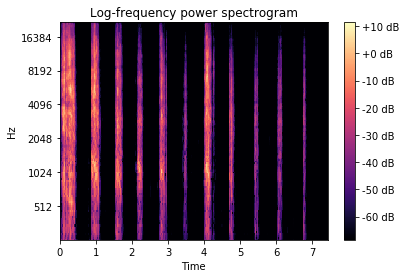

In [0]:
# PRUEBA
# os.chdir('train_curated')
# os.listdir()

specs = read_as_spectrogramsx3(conf, '009ca29f.wav',
                               trim_long_data=False,
                               debug_display=True)

In [0]:
maxi = specs[1].shape[1]
mini = specs[0].shape[1]
if mini < maxi:
    specs[0] = np.pad(specs[0], ((0, 0), (maxi - mini, 0)), mode="constant")

specarr = np.array(specs)
nonsil = del_silence(specarr, conf.n_fft, on='magnitude', thresh=-50)

# print(nonsil.shape)
# mini = np.amin(np.amin(nonsil))
# nonsil = nonsil - np.min(np.min(nonsil))
# specshow(nonsil[0])
# plt.matshow(nonsil[::-1, :])

len(nonsil)
# nonsil[0].shape

1

#### Proceso de eliminación de silencio

**FALTA:**

* **Se llama a la función de eliminación de silencios sobre los archivos cargados y transformados.**
* **Transformar archivo de etiquetas simultáneamente.**
* **No hay cómo separar etiquetas en archivos de múltiples de ellas una vez que se los separa por segmentos silenciosos.**

In [0]:
# import train_curated.csv labels file
labels = pd.read_csv("train_curated.csv")

In [0]:
batch_nonsil = []
for i in range(batch.shape[0]):
    spec = batch[i, :, :]
    nonsilsegs = del_silence(spec, conf.n_fft, thresh=-60)
    batch_nonsil.append(nonsilsegs)
    
    # repeat rows for each extracted non-silent segment
    string = data_oh.iloc[i].name
    if nonsilsegs.shape[0] > 1:
        for j in nonsilsegs.shape[0]:
            data_oh.loc[string+"_"+str(j)] = data_oh.loc[string]
data_oh.sort_values(by="fname")

### Padding

Se lleva los segmentos con el silencio ya filtrado a un largo uniforme para todo el dataset. Las dimensiones deben cumplir con los requisitos de los modelos preimplementados por PyTorch y FastAI en tales casos.

Tomando un `n_fft=1024` y un `hop_size=512` entonces la duración necesaria para que un archivo cumpla con la dimensión temporal igual a 224 es de:

$$224 \ frames \cdot \frac{512 \ muestras/frame}{44100\ muestras/s}=2.6 \ s$$
Archivos de duraciones menores a 2.6 s serán _paddeados_ centradamente. Tamaños de FFT mayores duplicarían el largo del audio.

En el eje vertical, la dimensionalidad se controlaría con la cantidad de filtros mel.

#### Function

In [0]:
def fit2square(file, data, index, data_new=None, stack=None, side=224,
               filename_col="fname", debug=False):
    """ Fit file to shape (channels, side, side), regardless of the amount of
    channels.
    
    Arguments:
        file - np.ndarray of shape (channels, h, w).
        data - pd.DataFrame().
        index - index of file in data.
        stack - np.ndarray of shape (M, channels, h, w) with M examples.
        side - int. Square matrix side.
        filename_col - string. Column for filenames in data.
 
    Returns:
        stack - new batch with M segmented arrays, each of shape
            (channels, side, side)
        data - new dataframe with segmented files' labels duplicated under
               new names.
    """
#     from functools import reduce
#
#     max_height = reduce(lambda x, y: max(x, y),
#                         [spec.shape[0] for spec in file])
# #     shorter = list(filter(lambda x: x.shape[1] < max_height, file))
#     shorter = list(filter(lambda i: file[i].shape[0] < max_height,
#                           range(len(file))))
#     if len(shorter) != 0:
#         for i in shorter:
#             file[i] = np.pad(file[i],
#                              ((0, 0),
#                               (max_height - file[i].shape[0], 0),
#                               (0, 0)),
#                              mode="constant")
#
# #     shorter = map(lambda spec: np.pad(spec,
# #                             ((0, 0),
# #                              (spec.shape[1] // 2, spec.shape[1] // 2),
# #                              (0, 0))), )
#
#     max_width = reduce(lambda x, y: max(x, y),
#                        [spec.shape[1] for spec in file])
# #     narrower = list(filter(lambda x: x.shape[2] < max_width, file))
#     narrower = list(filter(lambda i: file[i].shape[1] < max_width,
#                            range(len(file))))
#     if len(narrower) != 0:
#         for i in narrower:
#             file[i] = np.pad(file[i],
#                              ((0, 0),
#                               (0, 0),
#                               (0, max_width - file[i].shape[1])),
#                              mode="constant")
    
    h_maxi = file[1].shape[1]  # melspec height always <= cqt?
    h_mini = file[0].shape[1]
    w_maxi = file[0].shape[0]  # cqt width always <= melspec?
    w_mini = file[1].shape[0]
    if h_mini < h_maxi:
        file[0] = np.pad(file[0],
                         ((0, 0), (h_maxi - h_mini, 0)),
                         mode="constant")
    if w_mini < w_maxi:
        file[1:] = np.pad(file[1:],
                         ((0, 0), (0, 0), (0, w_maxi - w_mini)),
                         mode="constant")

    if data_new is None:
        # data_new = data.copy(deep=True)
        # data_new = pd.DataFrame([], index=None, columns=("fname","labels"))
        data_new = pd.DataFrame([])
    file = np.array(file)
    w_file = file.shape[2]  # channels, height, WIDTH
    h_file = file.shape[1]
    pad_height = side - h_file
    h_odd = pad_height % 2
    string = data.iloc[index].name
    shit = []

    if debug:
        print(f"\nFILE {index} ({string}). Shape: {file.shape}.")

    if w_file < side:
        pad_width = side - w_file
        w_odd = pad_width % 2
        file = np.pad(file,
                      ((0, 0),  # no channel padding
                       (pad_height // 2, pad_height // 2 + h_odd * 1),  # freq axis
                       (pad_width // 2, pad_width // 2 + w_odd * 1)),  # time axis
                      mode='constant')
        if stack is not None:
            stack = np.vstack((stack, np.expand_dims(file, axis=0)))
            data_new.loc[f"{string[:-4]}.wav"] = data.iloc[index]
        else:
            stack = np.expand_dims(file, axis=0)
            data_new = data_new.append(data.iloc[index])
        
        if debug:
            print(f"File {index} ({string}) is short. Shape after padding: {file.shape}.")
        
    else:
        spare_frames = w_file % side
        pad_width = side * (spare_frames != 0) - (spare_frames)
        w_odd = pad_width % 2
        file = np.pad(file, ((0, 0),  # no channel padding
                             (pad_height // 2, pad_height // 2 + h_odd * 1),  # freq padding
                             (pad_width // 2, pad_width // 2 + w_odd * 1)),  # time padding
                      mode="constant")  # no time axis padding yet

        if debug:
            print(f"File {index} ({string}) is long. Shape after pre-padding: {file.shape}.")

        for j in range(file.shape[2] // side):
            if stack is not None:
                stack = np.vstack((stack,
                                   np.expand_dims(file[:, :, j*side: (j+1)*side],
                                                  axis=0)))
                data_new.loc[f"{string[:-4]}_{j}.wav"] = data.iloc[index]
            else:
                stack = np.expand_dims(file[:, :, j*side: (j+1)*side], axis=0)
                data_new = data_new.append(data.iloc[i])

            # data_new = data_new.append(data.iloc[i])
            # if j > 0:
                # data_new.loc[f"{string[:-4]}_{j}.wav"] = data.loc[string]
            if debug:
                print(f"File {index} ({string}), segment {j}. Shape of segment: {stack[j,:,:,:].shape}.")

    # data_new = data_new.sort_values(by=filename_col)
    if debug:
        print(f"stack.shape = {stack.shape}")
    return stack, data_new

#### Process

In [0]:
"""
side: 224. Necessary dimension for torchvision and fastai models.
batch: list. List of "RGB" spectrogram arrays of shape (height, width, channels)
labels: pd.DataFrame. Labelling for each example.

stack. np.ndarray. New batch with square, segmented files according to the
    neural networks' input.
data_nu. pd.DataFrame. New dataframe with labels for segmented files.
"""

stack = None
data_nu = None
amount = len(batch)
i = 1

# for i in range(amount):
#     stack, data_nu = fit2square(batch[i], labels, i, stack=stack,
#                                 data_new=data_nu, debug=False,
#                                 side=224, filename_col="fname")
#     clear_output()
#     print(f"{i}/{amount} done. {100*i/amount}%")

for file in os.listdir("train_curated"):
    spec = np.genfromtxt(f"{file}_mel.csv"), \
           np.genfromtxt(f"{file}_cqtm.csv"), \
           np.genfromtxt(f"{file}_cqtp.csv")
    stack, data_nu = fit2square(spec, labels, i, stack=stack,
                                data_new=data_nu, debug=False,
                                side=224, filename_col="fname")
    clear_output()
    print(f"{i}/{amount} done. {100*i/amount}%")
    i+=1

1153/4970 done. 23.199195171026158%


In [0]:
labels

In [0]:
data_nu

,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,Gong,Gurgling,Harmonica,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Strum,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
029c1c70.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
028ddadb_0.wav,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
028ddadb_1.wav,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
028ddadb_2.wav,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
028ddadb_3.wav,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02a25949.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0164cba5_0.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0164cba5_1.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0164cba5_2.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### Normalization

Standardize to X~N(0, 1) or [0, 255].

Is it possible to apply Box-Cox transform to non-positive data? Implementation: scipy.stats.boxcox_normmax(x, method='all').

#### Box-Cox Transform

In [0]:
 def apply_boxcox(spec):
    lambdas = stats.boxcox_normmax(spec, method='all')
    if lambdas[0] != 0:
        spec_norm = ((spec + lambdas[1]) ** lambdas[0] - 1) / lambdas[0]
    else:
        spec_norm = np.log(spec + lambdas[1])
    return spec_norm

In [0]:
apply_boxcox(batch[0][0]).shape

ValueError: ignored

#### Image: 0-255

Fit into an image format. Based on daisukelab's implementation: https://www.kaggle.com/daisukelab .

In [0]:
def imagize(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1.e-7):
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

In [0]:
for m in range(stack.shape[0]):
    stack[m,:,:,:] = imagize(stack[m,:,:,:])
stack = stack.astype('uint8')

#### Normalization application

In [0]:
for i in range(len(batch)):
    r = imagize(batch[i][0])
    g = imagize(rgbspec[i][1])
    b = imagize(rgbspec[i][2])
    batch[i] = [r, g, b]

1
2
3
4


### Image storing

Save "images" to avoid transforming each time.

In [0]:
# os.mkdir("../imgs/")
# data_nu.to_csv("../train.csv", sep=",")
for i, rgbspec in enumerate(stack):
    imwrite(f"../imgs/{data_nu.iloc[i].name[:-4]}.png", np.transpose(rgbspec, (1, 2, 0)))  # transpose (c, h, w) to (h, w, c)

# Models

**FALTA:**
* **Modificar las capas de salida, dimensiones de salida y funciones de error de todos los modelos de acuerdo con la cantidad de clases y codificación de la salida en one-hot.**
* **Desarrollar cómo se combinan/concatenan las salidas de cada red neuronal para entrenar XGBoost.**
* **Cotejar que la función objetivo de XGBoost se condice con one-hot encoding.**

Se pretende usar distintas transformaciones de los audios a espectrograma para entrenar varias arquitecturas de redes neuronales en paralelo. El resultado de las redes neuronales confluye en un algoritmo de boosting (XGBoost) que aprende de los éxitos y fracasos de las redes para continuar minimizando el error.

## CNNs


Many successful image classification CNNs are used: ResNet 18, MobileNet v2, NASNet Mobile, SqueezeNet 1.0 and 1.1, ShuffleNet v2 and WideResNet.

### MobileNet v2

Based on Tony Lins' implementation:
https://github.com/tonylins/pytorch-mobilenet-v2

#### Blocks

In [0]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                         nn.BatchNorm2d(oup),
                         nn.ReLU6(inplace=True))

def conv_1x1_bn(inp, oup):
    return nn.Sequential(nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                         nn.BatchNorm2d(oup),
                         nn.ReLU6(inplace=True))


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(  # dw
                                      nn.Conv2d(hidden_dim, hidden_dim, 3,
                                                stride, 1, groups=hidden_dim,
                                                bias=False),
                                      nn.BatchNorm2d(hidden_dim),
                                      nn.ReLU6(inplace=True),
                                      # pw-linear
                                      nn.Conv2d(hidden_dim, oup, 1,
                                                1, 0, bias=False),
                                      nn.BatchNorm2d(oup))
        else:
            self.conv = nn.Sequential(  # pw
                                      nn.Conv2d(inp, hidden_dim, 1, 1, 0,
                                                bias=False),
                                      nn.BatchNorm2d(hidden_dim),
                                      nn.ReLU6(inplace=True),
                                      # dw
                                      nn.Conv2d(hidden_dim, hidden_dim, 3,
                                                stride, 1, bias=False
                                                groups=hidden_dim),
                                      nn.BatchNorm2d(hidden_dim),
                                      nn.ReLU6(inplace=True),
                                      # pw-linear
                                      nn.Conv2d(hidden_dim, oup, 1, 1, 0,
                                                bias=False),
                                      nn.BatchNorm2d(oup))

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

#### Model

In [0]:
class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * width_mult) \
            if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel,
                                               s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel,
                                               1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, n_class),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

### NASNet Mobile
**CHECK NORMALIZATION IN SETTINGS (compatibility with normalized databunch).**

Based on the implementation by Veronika Yurchuk:
https://github.com/veronikayurchuk/pretrained-models.pytorch/blob/master/pretrainedmodels/models/nasnet_mobile.py

#### Settings

In [0]:
settings = {
    'nasnetamobile': {
        'no_pretraining': {
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 80
        }
    }
}

#### Blocks

In [0]:
class MaxPoolPad(nn.Module):
    def __init__(self):
        super(MaxPoolPad, self).__init__()
        self.pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)

    def forward(self, x):
        x = self.pad(x)
        x = self.pool(x)
        x = x[:, :, 1:, 1:].contiguous()
        return x


class AvgPoolPad(nn.Module):
    def __init__(self, stride=2, padding=1):
        super(AvgPoolPad, self).__init__()
        self.pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.pool = nn.AvgPool2d(3, stride=stride, padding=padding, count_include_pad=False)

    def forward(self, x):
        x = self.pad(x)
        x = self.pool(x)
        x = x[:, :, 1:, 1:].contiguous()
        return x


class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, dw_kernel, dw_stride, dw_padding, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise_conv2d = nn.Conv2d(in_channels, in_channels, dw_kernel,
                                          stride=dw_stride,
                                          padding=dw_padding,
                                          bias=bias,
                                          groups=in_channels)
        self.pointwise_conv2d = nn.Conv2d(in_channels, out_channels, 1, stride=1, bias=bias)

    def forward(self, x):
        x = self.depthwise_conv2d(x)
        x = self.pointwise_conv2d(x)
        return x


class BranchSeparables(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, name=None, bias=False):
        super(BranchSeparables, self).__init__()
        self.relu = nn.ReLU()
        self.separable_1 = SeparableConv2d(in_channels, in_channels, kernel_size, stride, padding, bias=bias)
        self.bn_sep_1 = nn.BatchNorm2d(in_channels, eps=0.001, momentum=0.1, affine=True)
        self.relu1 = nn.ReLU()
        self.separable_2 = SeparableConv2d(in_channels, out_channels, kernel_size, 1, padding, bias=bias)
        self.bn_sep_2 = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1, affine=True)
        self.name = name

    def forward(self, x):
        x = self.relu(x)
        if self.name == 'specific':
            x = nn.ZeroPad2d((1, 0, 1, 0))(x)
        x = self.separable_1(x)
        if self.name == 'specific':
            x = x[:, :, 1:, 1:].contiguous()

        x = self.bn_sep_1(x)
        x = self.relu1(x)
        x = self.separable_2(x)
        x = self.bn_sep_2(x)
        return x


class BranchSeparablesStem(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
        super(BranchSeparablesStem, self).__init__()
        self.relu = nn.ReLU()
        self.separable_1 = SeparableConv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.bn_sep_1 = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1, affine=True)
        self.relu1 = nn.ReLU()
        self.separable_2 = SeparableConv2d(out_channels, out_channels, kernel_size, 1, padding, bias=bias)
        self.bn_sep_2 = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1, affine=True)

    def forward(self, x):
        x = self.relu(x)
        x = self.separable_1(x)
        x = self.bn_sep_1(x)
        x = self.relu1(x)
        x = self.separable_2(x)
        x = self.bn_sep_2(x)
        return x


class BranchSeparablesReduction(BranchSeparables):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, z_padding=1, bias=False):
        BranchSeparables.__init__(self, in_channels, out_channels, kernel_size, stride, padding, bias)
        self.padding = nn.ZeroPad2d((z_padding, 0, z_padding, 0))

    def forward(self, x):
        x = self.relu(x)
        x = self.padding(x)
        x = self.separable_1(x)
        x = x[:, :, 1:, 1:].contiguous()
        x = self.bn_sep_1(x)
        x = self.relu1(x)
        x = self.separable_2(x)
        x = self.bn_sep_2(x)
        return x


class CellStem0(nn.Module):
    def __init__(self, stem_filters, num_filters=42):
        super(CellStem0, self).__init__()
        self.num_filters = num_filters
        self.stem_filters = stem_filters
        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(self.stem_filters, self.num_filters, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(self.num_filters, eps=0.001, momentum=0.1, affine=True))

        self.comb_iter_0_left = BranchSeparables(self.num_filters, self.num_filters, 5, 2, 2)
        self.comb_iter_0_right = BranchSeparablesStem(self.stem_filters, self.num_filters, 7, 2, 3, bias=False)

        self.comb_iter_1_left = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_1_right = BranchSeparablesStem(self.stem_filters, self.num_filters, 7, 2, 3, bias=False)

        self.comb_iter_2_left = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)
        self.comb_iter_2_right = BranchSeparablesStem(self.stem_filters, self.num_filters, 5, 2, 2, bias=False)

        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(self.num_filters, self.num_filters, 3, 1, 1, bias=False)
        self.comb_iter_4_right = nn.MaxPool2d(3, stride=2, padding=1)

    def forward(self, x):
        x1 = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x1)
        x_comb_iter_0_right = self.comb_iter_0_right(x)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x1)
        x_comb_iter_1_right = self.comb_iter_1_right(x)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x1)
        x_comb_iter_2_right = self.comb_iter_2_right(x)
        x_comb_iter_2 = x_comb_iter_2_left + x_comb_iter_2_right

        x_comb_iter_3_right = self.comb_iter_3_right(x_comb_iter_0)
        x_comb_iter_3 = x_comb_iter_3_right + x_comb_iter_1

        x_comb_iter_4_left = self.comb_iter_4_left(x_comb_iter_0)
        x_comb_iter_4_right = self.comb_iter_4_right(x1)
        x_comb_iter_4 = x_comb_iter_4_left + x_comb_iter_4_right

        x_out = torch.cat([x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class CellStem1(nn.Module):
    def __init__(self, stem_filters, num_filters):
        super(CellStem1, self).__init__()
        self.num_filters = num_filters
        self.stem_filters = stem_filters
        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(2*self.num_filters, self.num_filters, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(self.num_filters, eps=0.001, momentum=0.1, affine=True))

        self.relu = nn.ReLU()
        self.path_1 = nn.Sequential()
        self.path_1.add_module('avgpool', nn.AvgPool2d(1, stride=2, count_include_pad=False))
        self.path_1.add_module('conv', nn.Conv2d(self.stem_filters, self.num_filters//2, 1, stride=1, bias=False))
        self.path_2 = nn.ModuleList()
        self.path_2.add_module('pad', nn.ZeroPad2d((0, 1, 0, 1)))
        self.path_2.add_module('avgpool', nn.AvgPool2d(1, stride=2, count_include_pad=False))
        self.path_2.add_module('conv', nn.Conv2d(self.stem_filters, self.num_filters//2, 1, stride=1, bias=False))

        self.final_path_bn = nn.BatchNorm2d(self.num_filters, eps=0.001, momentum=0.1, affine=True)

        self.comb_iter_0_left = BranchSeparables(self.num_filters, self.num_filters, 5, 2, 2, name='specific', bias=False)
        self.comb_iter_0_right = BranchSeparables(self.num_filters, self.num_filters, 7, 2, 3, name='specific', bias=False)

        # self.comb_iter_1_left = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_1_left = MaxPoolPad()
        self.comb_iter_1_right = BranchSeparables(self.num_filters, self.num_filters, 7, 2, 3, name='specific', bias=False)

        # self.comb_iter_2_left = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)
        self.comb_iter_2_left = AvgPoolPad()
        self.comb_iter_2_right = BranchSeparables(self.num_filters, self.num_filters, 5, 2, 2, name='specific', bias=False)

        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(self.num_filters, self.num_filters, 3, 1, 1, name='specific', bias=False)
        # self.comb_iter_4_right = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_4_right = MaxPoolPad()

    def forward(self, x_conv0, x_stem_0):
        x_left = self.conv_1x1(x_stem_0)

        x_relu = self.relu(x_conv0)
        # path 1
        x_path1 = self.path_1(x_relu)
        # path 2
        x_path2 = self.path_2.pad(x_relu)
        x_path2 = x_path2[:, :, 1:, 1:]
        x_path2 = self.path_2.avgpool(x_path2)
        x_path2 = self.path_2.conv(x_path2)
        # final path
        x_right = self.final_path_bn(torch.cat([x_path1, x_path2], 1))

        x_comb_iter_0_left = self.comb_iter_0_left(x_left)
        x_comb_iter_0_right = self.comb_iter_0_right(x_right)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_left)
        x_comb_iter_1_right = self.comb_iter_1_right(x_right)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_left)
        x_comb_iter_2_right = self.comb_iter_2_right(x_right)
        x_comb_iter_2 = x_comb_iter_2_left + x_comb_iter_2_right

        x_comb_iter_3_right = self.comb_iter_3_right(x_comb_iter_0)
        x_comb_iter_3 = x_comb_iter_3_right + x_comb_iter_1

        x_comb_iter_4_left = self.comb_iter_4_left(x_comb_iter_0)
        x_comb_iter_4_right = self.comb_iter_4_right(x_left)
        x_comb_iter_4 = x_comb_iter_4_left + x_comb_iter_4_right

        x_out = torch.cat([x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class FirstCell(nn.Module):
    def __init__(self, in_channels_left, out_channels_left, in_channels_right, out_channels_right):
        super(FirstCell, self).__init__()
        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(in_channels_right, out_channels_right, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(out_channels_right, eps=0.001, momentum=0.1, affine=True))

        self.relu = nn.ReLU()
        self.path_1 = nn.Sequential()
        self.path_1.add_module('avgpool', nn.AvgPool2d(1, stride=2, count_include_pad=False))
        self.path_1.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))
        self.path_2 = nn.ModuleList()
        self.path_2.add_module('pad', nn.ZeroPad2d((0, 1, 0, 1)))
        self.path_2.add_module('avgpool', nn.AvgPool2d(1, stride=2, count_include_pad=False))
        self.path_2.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))

        self.final_path_bn = nn.BatchNorm2d(out_channels_left * 2, eps=0.001, momentum=0.1, affine=True)

        self.comb_iter_0_left = BranchSeparables(out_channels_right, out_channels_right, 5, 1, 2, bias=False)
        self.comb_iter_0_right = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, bias=False)

        self.comb_iter_1_left = BranchSeparables(out_channels_right, out_channels_right, 5, 1, 2, bias=False)
        self.comb_iter_1_right = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, bias=False)

        self.comb_iter_2_left = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_3_left = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)
        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, bias=False)

    def forward(self, x, x_prev):
        x_relu = self.relu(x_prev)
        # path 1
        x_path1 = self.path_1(x_relu)
        # path 2
        x_path2 = self.path_2.pad(x_relu)
        x_path2 = x_path2[:, :, 1:, 1:]
        x_path2 = self.path_2.avgpool(x_path2)
        x_path2 = self.path_2.conv(x_path2)
        # final path
        x_left = self.final_path_bn(torch.cat([x_path1, x_path2], 1))

        x_right = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x_right)
        x_comb_iter_0_right = self.comb_iter_0_right(x_left)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_left)
        x_comb_iter_1_right = self.comb_iter_1_right(x_left)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_right)
        x_comb_iter_2 = x_comb_iter_2_left + x_left

        x_comb_iter_3_left = self.comb_iter_3_left(x_left)
        x_comb_iter_3_right = self.comb_iter_3_right(x_left)
        x_comb_iter_3 = x_comb_iter_3_left + x_comb_iter_3_right

        x_comb_iter_4_left = self.comb_iter_4_left(x_right)
        x_comb_iter_4 = x_comb_iter_4_left + x_right

        x_out = torch.cat([x_left, x_comb_iter_0, x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class NormalCell(nn.Module):
    def __init__(self, in_channels_left, out_channels_left, in_channels_right, out_channels_right):
        super(NormalCell, self).__init__()
        self.conv_prev_1x1 = nn.Sequential()
        self.conv_prev_1x1.add_module('relu', nn.ReLU())
        self.conv_prev_1x1.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))
        self.conv_prev_1x1.add_module('bn', nn.BatchNorm2d(out_channels_left, eps=0.001, momentum=0.1, affine=True))

        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(in_channels_right, out_channels_right, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(out_channels_right, eps=0.001, momentum=0.1, affine=True))

        self.comb_iter_0_left = BranchSeparables(out_channels_right, out_channels_right, 5, 1, 2, bias=False)
        self.comb_iter_0_right = BranchSeparables(out_channels_left, out_channels_left, 3, 1, 1, bias=False)

        self.comb_iter_1_left = BranchSeparables(out_channels_left, out_channels_left, 5, 1, 2, bias=False)
        self.comb_iter_1_right = BranchSeparables(out_channels_left, out_channels_left, 3, 1, 1, bias=False)

        self.comb_iter_2_left = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_3_left = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)
        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, bias=False)

    def forward(self, x, x_prev):
        x_left = self.conv_prev_1x1(x_prev)
        x_right = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x_right)
        x_comb_iter_0_right = self.comb_iter_0_right(x_left)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_left)
        x_comb_iter_1_right = self.comb_iter_1_right(x_left)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_right)
        x_comb_iter_2 = x_comb_iter_2_left + x_left

        x_comb_iter_3_left = self.comb_iter_3_left(x_left)
        x_comb_iter_3_right = self.comb_iter_3_right(x_left)
        x_comb_iter_3 = x_comb_iter_3_left + x_comb_iter_3_right

        x_comb_iter_4_left = self.comb_iter_4_left(x_right)
        x_comb_iter_4 = x_comb_iter_4_left + x_right

        x_out = torch.cat([x_left, x_comb_iter_0, x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class ReductionCell0(nn.Module):
    def __init__(self, in_channels_left, out_channels_left, in_channels_right, out_channels_right):
        super(ReductionCell0, self).__init__()
        self.conv_prev_1x1 = nn.Sequential()
        self.conv_prev_1x1.add_module('relu', nn.ReLU())
        self.conv_prev_1x1.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))
        self.conv_prev_1x1.add_module('bn', nn.BatchNorm2d(out_channels_left, eps=0.001, momentum=0.1, affine=True))

        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(in_channels_right, out_channels_right, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(out_channels_right, eps=0.001, momentum=0.1, affine=True))

        self.comb_iter_0_left = BranchSeparablesReduction(out_channels_right, out_channels_right, 5, 2, 2, bias=False)
        self.comb_iter_0_right = BranchSeparablesReduction(out_channels_right, out_channels_right, 7, 2, 3, bias=False)

        self.comb_iter_1_left = MaxPoolPad()
        self.comb_iter_1_right = BranchSeparablesReduction(out_channels_right, out_channels_right, 7, 2, 3, bias=False)

        self.comb_iter_2_left = AvgPoolPad()
        self.comb_iter_2_right = BranchSeparablesReduction(out_channels_right, out_channels_right, 5, 2, 2, bias=False)

        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparablesReduction(out_channels_right, out_channels_right, 3, 1, 1, bias=False)
        self.comb_iter_4_right = MaxPoolPad()

    def forward(self, x, x_prev):
        x_left = self.conv_prev_1x1(x_prev)
        x_right = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x_right)
        x_comb_iter_0_right = self.comb_iter_0_right(x_left)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_right)
        x_comb_iter_1_right = self.comb_iter_1_right(x_left)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_right)
        x_comb_iter_2_right = self.comb_iter_2_right(x_left)
        x_comb_iter_2 = x_comb_iter_2_left + x_comb_iter_2_right

        x_comb_iter_3_right = self.comb_iter_3_right(x_comb_iter_0)
        x_comb_iter_3 = x_comb_iter_3_right + x_comb_iter_1

        x_comb_iter_4_left = self.comb_iter_4_left(x_comb_iter_0)
        x_comb_iter_4_right = self.comb_iter_4_right(x_right)
        x_comb_iter_4 = x_comb_iter_4_left + x_comb_iter_4_right

        x_out = torch.cat([x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class ReductionCell1(nn.Module):
    def __init__(self, in_channels_left, out_channels_left, in_channels_right, out_channels_right):
        super(ReductionCell1, self).__init__()
        self.conv_prev_1x1 = nn.Sequential()
        self.conv_prev_1x1.add_module('relu', nn.ReLU())
        self.conv_prev_1x1.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))
        self.conv_prev_1x1.add_module('bn', nn.BatchNorm2d(out_channels_left, eps=0.001, momentum=0.1, affine=True))

        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(in_channels_right, out_channels_right, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(out_channels_right, eps=0.001, momentum=0.1, affine=True))

        self.comb_iter_0_left = BranchSeparables(out_channels_right, out_channels_right, 5, 2, 2, name='specific', bias=False)
        self.comb_iter_0_right = BranchSeparables(out_channels_right, out_channels_right, 7, 2, 3, name='specific', bias=False)

        # self.comb_iter_1_left = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_1_left = MaxPoolPad()
        self.comb_iter_1_right = BranchSeparables(out_channels_right, out_channels_right, 7, 2, 3, name='specific', bias=False)

        # self.comb_iter_2_left = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)
        self.comb_iter_2_left = AvgPoolPad()
        self.comb_iter_2_right = BranchSeparables(out_channels_right, out_channels_right, 5, 2, 2, name='specific', bias=False)

        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, name='specific', bias=False)
        # self.comb_iter_4_right = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_4_right =MaxPoolPad()

    def forward(self, x, x_prev):
        x_left = self.conv_prev_1x1(x_prev)
        x_right = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x_right)
        x_comb_iter_0_right = self.comb_iter_0_right(x_left)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_right)
        x_comb_iter_1_right = self.comb_iter_1_right(x_left)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_right)
        x_comb_iter_2_right = self.comb_iter_2_right(x_left)
        x_comb_iter_2 = x_comb_iter_2_left + x_comb_iter_2_right

        x_comb_iter_3_right = self.comb_iter_3_right(x_comb_iter_0)
        x_comb_iter_3 = x_comb_iter_3_right + x_comb_iter_1

        x_comb_iter_4_left = self.comb_iter_4_left(x_comb_iter_0)
        x_comb_iter_4_right = self.comb_iter_4_right(x_right)
        x_comb_iter_4 = x_comb_iter_4_left + x_comb_iter_4_right

        x_out = torch.cat([x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out

#### Model

In [0]:
class NASNetAMobile(nn.Module):
    """NASNetAMobile (4 @ 1056) """
    def __init__(self, num_classes=1001, stem_filters=32, penultimate_filters=1056, filters_multiplier=2):
        super(NASNetAMobile, self).__init__()
        self.num_classes = num_classes
        self.stem_filters = stem_filters
        self.penultimate_filters = penultimate_filters
        self.filters_multiplier = filters_multiplier

        filters = self.penultimate_filters // 24
        # 24 is default value for the architecture

        self.conv0 = nn.Sequential()
        self.conv0.add_module('conv', nn.Conv2d(in_channels=3, out_channels=self.stem_filters, kernel_size=3, padding=0, stride=2,
                                                bias=False))
        self.conv0.add_module('bn', nn.BatchNorm2d(self.stem_filters, eps=0.001, momentum=0.1, affine=True))

        self.cell_stem_0 = CellStem0(self.stem_filters, num_filters=filters // (filters_multiplier ** 2))
        self.cell_stem_1 = CellStem1(self.stem_filters, num_filters=filters // filters_multiplier)

        self.cell_0 = FirstCell(in_channels_left=filters, out_channels_left=filters//2, # 1, 0.5
                                in_channels_right=2*filters, out_channels_right=filters) # 2, 1
        self.cell_1 = NormalCell(in_channels_left=2*filters, out_channels_left=filters, # 2, 1
                                 in_channels_right=6*filters, out_channels_right=filters) # 6, 1
        self.cell_2 = NormalCell(in_channels_left=6*filters, out_channels_left=filters, # 6, 1
                                 in_channels_right=6*filters, out_channels_right=filters) # 6, 1
        self.cell_3 = NormalCell(in_channels_left=6*filters, out_channels_left=filters, # 6, 1
                                 in_channels_right=6*filters, out_channels_right=filters) # 6, 1

        self.reduction_cell_0 = ReductionCell0(in_channels_left=6*filters, out_channels_left=2*filters, # 6, 2
                                               in_channels_right=6*filters, out_channels_right=2*filters) # 6, 2

        self.cell_6 = FirstCell(in_channels_left=6*filters, out_channels_left=filters, # 6, 1
                                in_channels_right=8*filters, out_channels_right=2*filters) # 8, 2
        self.cell_7 = NormalCell(in_channels_left=8*filters, out_channels_left=2*filters, # 8, 2
                                 in_channels_right=12*filters, out_channels_right=2*filters) # 12, 2
        self.cell_8 = NormalCell(in_channels_left=12*filters, out_channels_left=2*filters, # 12, 2
                                 in_channels_right=12*filters, out_channels_right=2*filters) # 12, 2
        self.cell_9 = NormalCell(in_channels_left=12*filters, out_channels_left=2*filters, # 12, 2
                                 in_channels_right=12*filters, out_channels_right=2*filters) # 12, 2

        self.reduction_cell_1 = ReductionCell1(in_channels_left=12*filters, out_channels_left=4*filters, # 12, 4
                                               in_channels_right=12*filters, out_channels_right=4*filters) # 12, 4

        self.cell_12 = FirstCell(in_channels_left=12*filters, out_channels_left=2*filters, # 12, 2
                                 in_channels_right=16*filters, out_channels_right=4*filters) # 16, 4
        self.cell_13 = NormalCell(in_channels_left=16*filters, out_channels_left=4*filters, # 16, 4
                                  in_channels_right=24*filters, out_channels_right=4*filters) # 24, 4
        self.cell_14 = NormalCell(in_channels_left=24*filters, out_channels_left=4*filters, # 24, 4
                                  in_channels_right=24*filters, out_channels_right=4*filters) # 24, 4
        self.cell_15 = NormalCell(in_channels_left=24*filters, out_channels_left=4*filters, # 24, 4
                                  in_channels_right=24*filters, out_channels_right=4*filters) # 24, 4

        self.relu = nn.ReLU()
        self.avg_pool = nn.AvgPool2d(7, stride=1, padding=0)
        self.dropout = nn.Dropout()
        self.last_linear = nn.Linear(24*filters, self.num_classes)

    def features(self, input):
        x_conv0 = self.conv0(input)
        x_stem_0 = self.cell_stem_0(x_conv0)
        x_stem_1 = self.cell_stem_1(x_conv0, x_stem_0)

        x_cell_0 = self.cell_0(x_stem_1, x_stem_0)
        x_cell_1 = self.cell_1(x_cell_0, x_stem_1)
        x_cell_2 = self.cell_2(x_cell_1, x_cell_0)
        x_cell_3 = self.cell_3(x_cell_2, x_cell_1)

        x_reduction_cell_0 = self.reduction_cell_0(x_cell_3, x_cell_2)

        x_cell_6 = self.cell_6(x_reduction_cell_0, x_cell_3)
        x_cell_7 = self.cell_7(x_cell_6, x_reduction_cell_0)
        x_cell_8 = self.cell_8(x_cell_7, x_cell_6)
        x_cell_9 = self.cell_9(x_cell_8, x_cell_7)

        x_reduction_cell_1 = self.reduction_cell_1(x_cell_9, x_cell_8)

        x_cell_12 = self.cell_12(x_reduction_cell_1, x_cell_9)
        x_cell_13 = self.cell_13(x_cell_12, x_reduction_cell_1)
        x_cell_14 = self.cell_14(x_cell_13, x_cell_12)
        x_cell_15 = self.cell_15(x_cell_14, x_cell_13)
        return x_cell_15

    def logits(self, features):
        x = self.relu(features)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.last_linear(x)
        x = nn.Softmax(1)(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x


def nasnetamobile(num_classes=1001, pretrained='imagenet'):
    r"""NASNetALarge model architecture from the
    `"NASNet" <https://arxiv.org/abs/1707.07012>`_ paper.
    """
    net_settings = settings['nasnetamobile']['no_pretraining']
    model = NASNetAMobile(num_classes=num_classes)
    model.input_space = net_settings['input_space']
    model.input_size = net_settings['input_size']
    model.input_range = net_settings['input_range']

    model.mean = net_settings['mean']
    model.std = net_settings['std']
    return model

### ResNet 18/34

#### Instantiation

In [0]:
resnet = cnn_learner(data, models.resnet18, pretrained=False)
resnet.unfreeze()
resnet.train()

NameError: ignored

In [0]:
resnet = cnn_learner(data, models.resnet34, pretrained=False)
resnet.unfreeze()
resnet.train()

In [0]:
resnet.model

### SqueezeNet 1.0

PyTorch implementation, pre-trained parameters discarded.

#### Instantiation

In [0]:
squeezenet0 = cnn_learner(data, models.squeezenet1_0, pretrained=False)
squeezenet0.unfreeze()
squeezenet0.train()
# batchnorm layers "behave" differently during training and prediction stages

### SqueezeNet 1.1

#### Instantiation

In [0]:
squeezenet1 = cnn_learner(data, models.squeezenet1_1, pretrained=False)
squeezenet1.unfreeze()
squeezenet1.train()  # cambia el comportamiento durante entrenamiento y evaluación por capas como batchnorm

### ShuffleNet v2

PyTorch implementation, pre-trained parameters discarded.

#### Instantiation

In [0]:
shufflenet = cnn_learner(data, models.shufflenetv2, pretrained=False)
shufflenet.unfreeze()
shufflenet.train()
# batchnorm layers behave differently during training and prediction stages

### WideResNet
**CHECK HYPERPARAMETERS**

Fast.ai implementation,pre-trained parameters discarded.
Details: https://docs.fast.ai/vision.models.html

#### Instantiation

In [0]:
wrn = cnn_learner(data, WideResNet(), pretrained=False)  # permite configurar parámetros de la red
wrn = cnn_learner(data, wrn_22, pretrained=False)  # misma implementación pero con parámteros prefijados

## XGBoost
**XGBoost tutorial: https://www.datacamp.com/community/tutorials/xgboost-in-python**

The outputs (**probits or logits?**) of the various neural networks must be concatenated and fed to the XGBoost.

### Instanciación del clasificador
**Ver hiperparámetros. Ojo con la salida de la función objective, chequear.**

In [0]:
xgb_reg = XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

# Training

A la hora de entrenar, se llama a un objeto Learner (fastai) cuyos argumentos son data (de tipo DataBunch de fastai, que engloba ejemplos y etiquetas), model (el modelo nn.Sequential instanciado con la función anterior) y metrics (autoexplicativo); este objeto se corre a continuación con su método fit(n), donde n es el número de épocas o iteraciones?.

Detalle: el tamaño del mini batch no se configura en el Learner o a la hora de fit() sino antes, en la creación del DataBunch.

Conviene, supuestamente, entrenar con la técnica 1cycle, que varía a lo largo de las iteraciones la tasa de aprendizaje, los momentos del optimizador y el weight decay. Sirve para lograr tasas mayores y algunos dicen que como regularización. Tenemos que estar prestos entonces para aflojarle un poco al dropout (o L1, L2 o lo que usemos). Si quieren chusmear sobre el tema les recomiendo https://docs.fast.ai/callbacks.one_cycle.html y https://sgugger.github.io/the-1cycle-policy.html .

**YEITE: parece que la técnica de augmentation MixUp está implementada dentro de la clase Learner.**

In [0]:
config = {"batch_size": 32,
          "curated_validation_percentage": 0.1,
          "noisy_validation_percentage": 0.1}

## Image reading

In [0]:
# path = untar_data()
# data = ImageDataBunch.from_folder(path)  # fastai.vision import for ImageNet style organization of data

# data = (ImageList.from_folder(path)  #Where to find the data? -> in path and its subfolders
#         .split_by_folder()           #How to split in train/valid? -> use the folders
#         .label_from_folder()         #How to label? -> depending on the folder of the filenames
#         .add_test_folder()           #Optionally add a test set (here default name is test)
#         .transform(tfms, size=64)    #Data augmentation? -> use tfms with a size of 64
#         .databunch())                #Finally? -> use the defaults for conversion to ImageDataBunch

# yet another way
# multi class classification with no previous train/dev split
# path = untar_data()
# data = ImageDataBunch.from_csv(planet, folder='train', size=128, suffix='.jpg', label_delim = ' ', ds_tfms=planet_tfms)  # para qué?

tfms = get_transforms(do_flip=False, max_lightning=0.2, p_lightning=0.1
                      max_rotate=0, max_zoom=0, max_warp=0.)

data_curated = (ImageList.from_csv(path, 'train_curated.csv', folder='train_curated', suffix='.png')
                .split_by_rand_pct(config["curated_validation_percentage"])
                .label_from_df(label_delim=',')
                #How to label? -> use the second column of the csv file and split the tags by ','
                .transform(tfms, size=224)
                #Data augmentation? -> use tfms with a size of 128
                .databunch(bs=config["batch_size"])
                .normalize()
                )

data_noisy = (ImageList.from_csv(path, 'train_noisy.csv', folder='train_noisy', suffix='.png')
              #Where to find the data? -> in planet 'train' folder
              .split_by_rand_pct(config["noisy_validation_percentage"])
              #How to split in train/valid? -> randomly with the default 20% in valid
              .label_from_df(label_delim=',')
              #How to label? -> use the second column of the csv file and split the tags by ','
              .transform(tfms, size=224)
              #Data augmentation? -> use tfms with a size of 128
              .databunch(bs=batch_size)
              .normalize()
             )

**Normalization**

In [0]:
curated_mel_mean = data_curated.stats[0][0]
curated_cqtmag_mean = data_curated.stats[0][1]
curated_cqtphase_mean = data_curated.stats[0][2]
curated_mel_std = data_curated.stats[1][0]
curated_cqtmag_std = data_curated.stats[1][1]
curated_cqtphase_std = data_curated.stats[1][2]
noisy_mel_mean = data_noisy.stats[0][0]
noisy_cqtmag_mean = data_noisy.stats[0][1]
noisy_cqtphase_mean = data_noisy.stats[0][2]
noisy_mel_std = data_noisy.stats[1][0]
noisy_cqtmag_std = data_noisy.stats[1][1]
noisy_cqtphase_std = data_noisy.stats[1][2]

## Models instantiations

In [0]:
# ELEGIR EL MODELO EN LA SIGUIENTE LINEA
# model = rdsf_net()
learn = Learner(data, model, metrics=[accuracy], bn_wd=False, path=)  # capas BN sin weight decay
# INCLUIR MixUp en los argumentos de Learner() en la línea anterior

## Metrics

Label-weighted label-ranking average precision (lwlrap).

In [0]:
# Core calculation of label precisions for one test sample.

def _one_sample_positive_class_precisions(scores, truth):
  """Calculate precisions for each true class for a single sample.
  
  Args:
    scores: np.array of (num_classes,) giving the individual classifier scores.
    truth: np.array of (num_classes,) bools indicating which classes are true.

  Returns:
    pos_class_indices: np.array of indices of the true classes for this sample.
    pos_class_precisions: np.array of precisions corresponding to each of those
      classes.
  """
  num_classes = scores.shape[0]
  pos_class_indices = np.flatnonzero(truth > 0)
  # Only calculate precisions if there are some true classes.
  if not len(pos_class_indices):
    return pos_class_indices, np.zeros(0)
  # Retrieval list of classes for this sample. 
  retrieved_classes = np.argsort(scores)[::-1]
  # class_rankings[top_scoring_class_index] == 0 etc.
  class_rankings = np.zeros(num_classes, dtype=np.int)
  class_rankings[retrieved_classes] = range(num_classes)
  # Which of these is a true label?
  retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
  retrieved_class_true[class_rankings[pos_class_indices]] = True
  # Num hits for every truncated retrieval list.
  retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
  # Precision of retrieval list truncated at each hit, in order of pos_labels.
  precision_at_hits = (
      retrieved_cumulative_hits[class_rankings[pos_class_indices]] / 
      (1 + class_rankings[pos_class_indices].astype(np.float)))
  return pos_class_indices, precision_at_hits


In [0]:
# All-in-one calculation of per-class lwlrap.

def calculate_per_class_lwlrap(truth, scores):
  """Calculate label-weighted label-ranking average precision.
  
  Arguments:
    truth: np.array of (num_samples, num_classes) giving boolean ground-truth
      of presence of that class in that sample.
    scores: np.array of (num_samples, num_classes) giving the classifier-under-
      test's real-valued score for each class for each sample.
  
  Returns:
    per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each 
      class.
    weight_per_class: np.array of (num_classes,) giving the prior of each 
      class within the truth labels.  Then the overall unbalanced lwlrap is 
      simply np.sum(per_class_lwlrap * weight_per_class)
  """
  assert truth.shape == scores.shape
  num_samples, num_classes = scores.shape
  # Space to store a distinct precision value for each class on each sample.
  # Only the classes that are true for each sample will be filled in.
  precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
  for sample_num in range(num_samples):
    pos_class_indices, precision_at_hits = (
      _one_sample_positive_class_precisions(scores[sample_num, :], 
                                            truth[sample_num, :]))
    precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
        precision_at_hits)
  labels_per_class = np.sum(truth > 0, axis=0)
  weight_per_class = labels_per_class / float(np.sum(labels_per_class))
  # Form average of each column, i.e. all the precisions assigned to labels in
  # a particular class.
  per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) / 
                      np.maximum(1, labels_per_class))
  # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
  #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
  #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
  #                = np.sum(per_class_lwlrap * weight_per_class)
  return per_class_lwlrap, weight_per_class

In [0]:
# Calculate the overall lwlrap using sklearn.metrics function.

def calculate_overall_lwlrap_sklearn(truth, scores):
  """Calculate the overall lwlrap using sklearn.metrics.lrap."""
  # sklearn doesn't correctly apply weighting to samples with no labels, so just skip them.
  sample_weight = np.sum(truth > 0, axis=1)
  nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
  overall_lwlrap = sklearn.metrics.label_ranking_average_precision_score(
      truth[nonzero_weight_sample_indices, :] > 0, 
      scores[nonzero_weight_sample_indices, :], 
      sample_weight=sample_weight[nonzero_weight_sample_indices])
  return overall_lwlrap

In [0]:
# Accumulator object version.

class lwlrap_accumulator(object):
  """Accumulate batches of test samples into per-class and overall lwlrap."""  

  def __init__(self):
    self.num_classes = 0
    self.total_num_samples = 0
  
  def accumulate_samples(self, batch_truth, batch_scores):
    """Cumulate a new batch of samples into the metric.
    
    Args:
      truth: np.array of (num_samples, num_classes) giving boolean
        ground-truth of presence of that class in that sample for this batch.
      scores: np.array of (num_samples, num_classes) giving the 
        classifier-under-test's real-valued score for each class for each
        sample.
    """
    assert batch_scores.shape == batch_truth.shape
    num_samples, num_classes = batch_truth.shape
    if not self.num_classes:
      self.num_classes = num_classes
      self._per_class_cumulative_precision = np.zeros(self.num_classes)
      self._per_class_cumulative_count = np.zeros(self.num_classes, 
                                                  dtype=np.int)
    assert num_classes == self.num_classes
    for truth, scores in zip(batch_truth, batch_scores):
      pos_class_indices, precision_at_hits = (
        _one_sample_positive_class_precisions(scores, truth))
      self._per_class_cumulative_precision[pos_class_indices] += (
        precision_at_hits)
      self._per_class_cumulative_count[pos_class_indices] += 1
    self.total_num_samples += num_samples

  def per_class_lwlrap(self):
    """Return a vector of the per-class lwlraps for the accumulated samples."""
    return (self._per_class_cumulative_precision / 
            np.maximum(1, self._per_class_cumulative_count))

  def per_class_weight(self):
    """Return a normalized weight vector for the contributions of each class."""
    return (self._per_class_cumulative_count / 
            float(np.sum(self._per_class_cumulative_count)))

  def overall_lwlrap(self):
    """Return the scalar overall lwlrap for cumulated samples."""
    return np.sum(self.per_class_lwlrap() * self.per_class_weight())


In [0]:
# Random test data.
num_samples = 100
num_labels = 20

truth = np.random.rand(num_samples, num_labels) > 0.5
# Ensure at least some samples with no truth labels.
truth[0:1, :] = False

scores = np.random.rand(num_samples, num_labels)

In [0]:
per_class_lwlrap, weight_per_class = calculate_per_class_lwlrap(truth, scores)
print("lwlrap from per-class values=", np.sum(per_class_lwlrap * weight_per_class))
print("lwlrap from sklearn.metrics =", calculate_overall_lwlrap_sklearn(truth, scores))

lwlrap from per-class values= 0.5819169218307428
lwlrap from sklearn.metrics = 0.581916921830743


In [0]:
# Test of accumulator version.
accumulator = lwlrap_accumulator()
batch_size = 12
for base_sample in range(0, scores.shape[0], batch_size):
  accumulator.accumulate_samples(
      truth[base_sample : base_sample + batch_size, :], 
      scores[base_sample : base_sample + batch_size, :])
print("cumulative_lwlrap=", accumulator.overall_lwlrap())
print("total_num_samples=", accumulator.total_num_samples)


cumulative_lwlrap= 0.5819169218307428
total_num_samples= 100


## Training with 1cycle

1) Buscar la tasa de aprendizaje óptima máxima con learner.lr_find().

2) Plotear y elegir con ojímetría una relativamente menor, un orden de magnitud menor más monedas.

3) Pasarla como argumento a fit_one_cycle().

Para elegir **otros hiperparámetros**, como weight decay o probabilidad de dropout, se recomienda probar distintos valores en lr_finder() y hasta en fit_one_cycle(). Nunca NO probar con lr_finder() porque cambiar algo puede hacer que la misma tasa que antes dé divergente.

### Finding LR

In [0]:
# Buscar el lr como aquél un poco menor al que hace que se vaya todo a la mierda
learn.lr_find(learn:Learner, start_lr:Floats=1e-07, end_lr:Floats=10,
                num_it:int=100, stop_div:bool=True, wd:float=None)
learn.recorder.plot_lr(show_moms=True)  # elegir visualmente el lr que se le va a pasar a fit_one_cycle() como arg
mom_max = 0  # reemplazar acá

### Fitting

In [0]:
# Equivalente simple a One Cycle
learn.fit_one_cycle(1, max_lr=mom_max)
# learn.recorder.plot_lr(show_moms=True)  # chusmear
# learn.recorder.plot_metrics()  # chusmear

## Save/export

In [0]:
# learn.save('stage-#')
# learn = load_learner()
# learn.export()

## Interpretation

In [0]:
# learn.load_learner('stage-#')
# interp = ClassificationInterpretation.from_learner(learn)
# inter.plot_confusion_matrix()
# .top_losses()  # error analysis
# ds, idxs = DatasetFormatter().from_toplosses(learn_cln)  # esto cómo funciona?


## XGBoost training

### Train/test data split para el XGBoost

Crear un nuevo dataset en el que la X_train es la concatenación de las predicciones de las redes neuronales **(en formato categórico numérico o one hot encoding?)** e y_train las ground truths todavía.

**Transformar el nuevo dataset en DMatrix**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Entrenamiento

In [0]:
xgb_reg.fit(X_train, y_train)

### Ploteo del árbol

In [0]:
xgb.plot_importance(xgb_reg)
xgb.plot_tree(xgb_reg)
xgb.to_graphviz(xgb_reg)

# Prediction

La etapa de predicción seguramente deba tener como **entrada no el espectrograma sino el archivo crudo** (esto podría complicar los tiempos). Entonces el flujo debería ser tal cual el de los datos de entrenamiento automatizado:

    audio->transformaciones en paralelo->eliminación de silencio->predicción de redes neuronales->concatenación->predicción de xgboost

In [0]:
# Predicción (solo sirve para individual?)
# learn.predict(img)

# Predicción en un test set, pasando un ItemList como argumento
path_to_folder = ""
learn = load_learner(mnist, test=ImageList.from_folder(path_to_folder))

Esto sirve de algo?

In [0]:
# Starlette web app toolkit
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })